<a href="https://colab.research.google.com/github/Debajyoti2004/Encryptix/blob/main/Spam_SMS_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split



Load SPAM SMS CLASSIFICATION data--

In [2]:

# Attempt to read the CSV file with ISO-8859-1 encoding
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')
df.tail()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


Analysing the data ( data is balanced or not)--

1.   because no. of ham is far more than no. of spam so data is disbalanced
2.   and most of the values in unnamed 1,2,3 column are NAN


    


In [3]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df.tail()

,v1,v2
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


Disbalanced data---

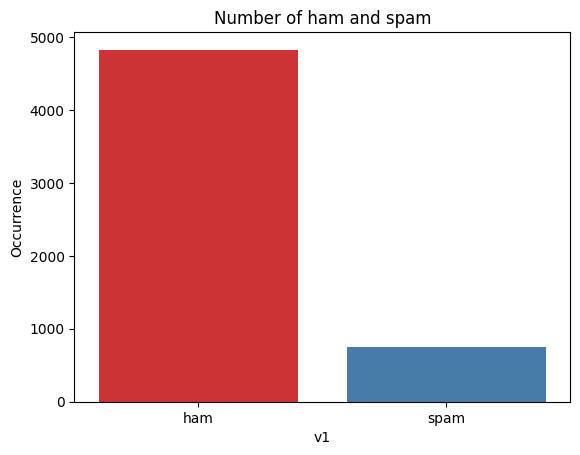

In [5]:
# Create the count plot
sns.countplot(x='v1', palette='Set1', hue='v1', data=df, hue_order=['ham', 'spam'])

# Set title and labels
plt.title("Number of ham and spam")
plt.ylabel('Occurrence')

# Show the plot
plt.show()

In [6]:
ham=df[df['v1']=='ham']
spam=df[df['v1']=='spam']
print(f"ham shape: {ham.shape}")
print(f"spam shape: {spam.shape}")

ham shape: (4825, 2)
spam shape: (747, 2)


Downsampling the data ( equal amount of ham and spam present in new dataframe)

In [7]:
ham_new=ham.sample(spam.shape[0])
print(f"ham_new shape: {ham_new.shape}")
df_new=pd.concat([ham_new,spam])
df_new.head()
print(f"df_new shape: {df_new.shape}")

ham_new shape: (747, 2)
df_new shape: (1494, 2)


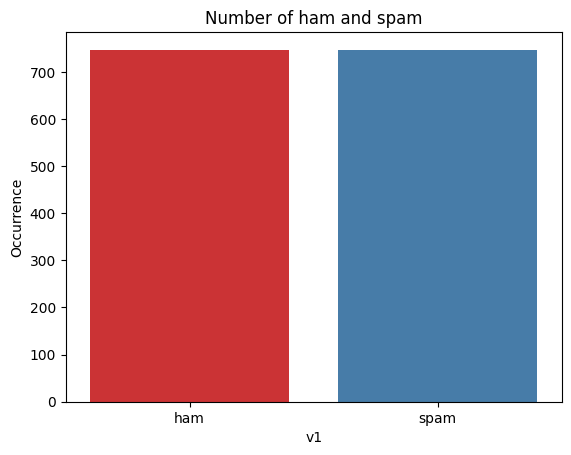

In [8]:
#after down sampling
# Create the count plot
sns.countplot(x='v1', palette='Set1', hue='v1', data=df_new, hue_order=['ham', 'spam'])

# Set title and labels
plt.title("Number of ham and spam")
plt.ylabel('Occurrence')

# Show the plot
plt.show()

In [9]:
df_new['v1'] = df_new['v1'].map({'spam': 1, 'ham': 0})
df_new.tail()

,v1,v2
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...
5567,1,This is the 2nd time we have tried 2 contact u...


Now load message and label in X,Y

In [10]:
X=df_new['v2']
Y=df_new['v1']
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

X shape: (1494,)
Y shape: (1494,)


Finding length of longest message present in dataset:

In [11]:
def max_num_word_in_sentence(data):
  max_length=-100
  for sentence in data:
    max_num_word=len(sentence.split())
    if max_num_word > max_length:
      max_length=max_num_word

  return max_length

In [12]:
max_len=max_num_word_in_sentence(X)
print(f"max_length sentence in data X: {max_len}")

max_length sentence in data X: 96


Splitting Dataset

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (1195,)
x_test shape: (299,)
y_train shape: (1195,)
y_test shape: (299,)


In [14]:
vocab_size=500
max_len=89

Tokenizer

In [15]:
tokenizer=Tokenizer(num_words=vocab_size,oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
word_index=tokenizer.word_index

print(f"word index={word_index}")
print(f"length of word index={len(word_index)}")


word index={'<OOV>': 1, 'to': 2, 'you': 3, 'a': 4, 'i': 5, 'call': 6, 'the': 7, 'u': 8, 'your': 9, 'for': 10, 'is': 11, 'and': 12, '2': 13, 'free': 14, 'now': 15, 'or': 16, 'in': 17, 'have': 18, 'of': 19, 'on': 20, 'ur': 21, '4': 22, 'txt': 23, 'are': 24, 'from': 25, 'me': 26, 'with': 27, 'my': 28, 'text': 29, 'this': 30, 'get': 31, 'stop': 32, 'just': 33, 'it': 34, 'mobile': 35, 'we': 36, 'reply': 37, 'claim': 38, 'no': 39, 'that': 40, 'be': 41, 'only': 42, 'if': 43, 'will': 44, 'www': 45, 'out': 46, 'so': 47, 'at': 48, 'not': 49, 'can': 50, 'new': 51, 'our': 52, 'send': 53, 'cash': 54, 'but': 55, 'prize': 56, 'do': 57, 'go': 58, 'please': 59, "i'm": 60, '1': 61, 'won': 62, 't': 63, 'win': 64, 'uk': 65, 'who': 66, '150p': 67, 'all': 68, 'msg': 69, 'nokia': 70, 'want': 71, 'how': 72, 'up': 73, 'week': 74, 'urgent': 75, 'tone': 76, 'what': 77, '50': 78, 'know': 79, 'been': 80, 'com': 81, 'co': 82, 'contact': 83, 'phone': 84, 'service': 85, 'ok': 86, 'every': 87, 'day': 88, '16': 89, 'as

Padding

In [16]:
train_sequence=tokenizer.texts_to_sequences(x_train)
test_sequence=tokenizer.texts_to_sequences(x_test)
print(f"first training sequence: {train_sequence[0]}")
print(f"first test sequence={test_sequence[0]}")
train_sequence_padded=pad_sequences(train_sequence,maxlen=max_len,padding='post',truncating='post',value=0)
test_sequence_padded=pad_sequences(test_sequence,maxlen=max_len,padding='post',truncating='post',value=0)
print(f"train_sequence_padded shape: {train_sequence_padded.shape}")
print(f"test_sequence_padded shape: {test_sequence_padded.shape}")

first training sequence: [173, 33, 1, 411, 4, 1, 19, 1, 227, 1, 17, 1, 12, 5, 379, 146, 43, 1, 1, 1, 16, 33, 1]
first test sequence=[75, 316, 1, 10, 1, 1, 134, 11, 9, 1, 88, 13, 112, 46, 227, 1, 1, 236, 45, 1, 81, 111, 11, 4, 1, 1, 1, 10, 3]
train_sequence_padded shape: (1195, 89)
test_sequence_padded shape: (299, 89)


In [17]:
from tensorflow.keras.layers import GlobalAveragePooling1D

def y(y_pred,threshold):
  y_pred=tf.where(y_pred<threshold,0,1)
  return y_pred

Spam Detection version 1 without using LSTM:

In [18]:
class SpamDetectionModel_V1(Model):
  def __init__(self,vocab_size,embedding_dim,max_len,dropout,**kwargs):
    super(SpamDetectionModel_V1,self).__init__(**kwargs)
    self.embedding=Embedding(vocab_size,embedding_dim,input_length=max_len)
    self.average=GlobalAveragePooling1D()
    self.dense=Dense(1,activation='sigmoid')

  def call(self,inputs):
    embeddings=self.embedding(inputs)
    x=self.average(embeddings)
    output=self.dense(x)
    return output


In [19]:
vocab_size=500
embedding_dim=16
max_len=89
dropout=0.2

In [20]:
input=Input(shape=(max_len,))
model_v1=SpamDetectionModel_V1(vocab_size=vocab_size,embedding_dim=embedding_dim,max_len=max_len,dropout=dropout)
output=model_v1(input)
model_v1.summary()


Model: "spam_detection_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8000      
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               multiple                  17        
                                                                 
Total params: 8017 (31.32 KB)
Trainable params: 8017 (31.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
from tensorflow.keras.optimizers import Adam
opt=Adam(learning_rate=1e-3)
loss=tf.keras.losses.BinaryCrossentropy()
model_v1.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-5,         # Lower bound on the learning rate
    verbose=1            # Verbosity mode. 1: update messages, 0: silent
)


early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement before stopping the training
    restore_best_weights=True,  # Whether to restore model weights from the epoch with the best value of the monitored metric
    verbose=1            # Verbosity mode. 1: update messages, 0: silent
)

In [25]:
model_v1_history=model_v1.fit(train_sequence_padded,y_train,epochs=50,validation_data=(test_sequence_padded,y_test),callbacks=[reduce_lr,early_stopping])

Epoch 1/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0640 - accuracy: 0.9799 - val_loss: 0.1191 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0633 - accuracy: 0.9808 - val_loss: 0.1195 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 0s 6ms/step - loss: 0.0627 - accuracy: 0.9799 - val_loss: 0.1184 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0620 - accuracy: 0.9816 - val_loss: 0.1203 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0612 - accuracy: 0.9799 - val_loss: 0.1185 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 6/50
35/38 [==========================>...] - ETA: 0s - loss: 0.0626 - accuracy: 0.9812
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
38/38 [==============================] - 0s 5ms/step - loss: 0.0

In [26]:
model_v1.evaluate(test_sequence_padded,y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9565


[0.11837680637836456, 0.95652174949646]

In [27]:
y_pred_train=model_v1.predict(train_sequence_padded)
y_pred_test=model_v1.predict(test_sequence_padded)
print(f"y_pred_train shape: {y_pred_train.shape}")
print(f"y_pred_test shape: {y_pred_test.shape}")

from sklearn.metrics import accuracy_score
y_pred_train=y(y_pred_train,threshold=0.5)
y_pred_test=y(y_pred_test,threshold=0.5)
print(f"accuracy train: {accuracy_score(y_train,y_pred_train)}")
print(f"accuracy test: {accuracy_score(y_test,y_pred_test)}")



10/10 [==============================] - 0s 2ms/step
y_pred_train shape: (1195, 1)
y_pred_test shape: (299, 1)
accuracy train: 0.9824267782426779
accuracy test: 0.9565217391304348


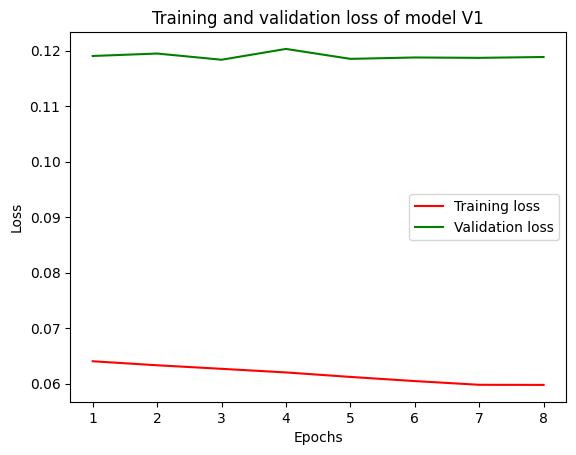

In [28]:


# Extracting loss values from the training history
model_1_loss = model_v1_history.history['loss']
model_1_val_loss = model_v1_history.history['val_loss']
epochs = range(1, len(model_1_loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, model_1_loss, c='r', label='Training loss')
plt.plot(epochs, model_1_val_loss, c='g', label='Validation loss')
plt.title('Training and validation loss of model V1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()


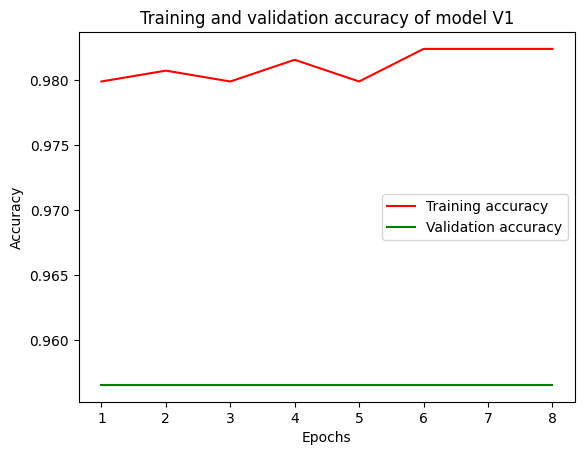

In [29]:
#accuracy plot


# Extracting accuracy values from the training history
model_1_accuracy = model_v1_history.history['accuracy']
model_1_val_accuracy = model_v1_history.history['val_accuracy']
epochs = range(1, len(model_1_accuracy) + 1)

# Plotting the training and validation accuracy
plt.plot(epochs, model_1_accuracy, c='r', label='Training accuracy')
plt.plot(epochs, model_1_val_accuracy, c='g', label='Validation accuracy')
plt.title('Training and validation accuracy of model V1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # Correctly specifying the location of the legend
plt.show()


Spam Detection Model version 2 with LSTM :

In [44]:
from tensorflow.keras.layers import Activation
class SpamDetectionModel_V2(Model):
    def __init__(self, vocab_size, embedding_dim, max_len, dropout, threshold, **kwargs):
        super(SpamDetectionModel_V2, self).__init__(**kwargs)
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(128, return_sequences=False)
        self.dropout = Dropout(rate=dropout)
        self.dense = Dense(1)
        self.activation=Activation('sigmoid')
        self.threshold = threshold

    def call(self, inputs):
        embeddings = self.embedding(inputs)
        x = self.lstm1(embeddings)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.dense(x)
        output=self.activation(x)
        return output



In [45]:
vocab_size=500
embedding_dim=16
max_len=89
dropout=0.2
threshold=0.5

In [46]:

model_v2 = SpamDetectionModel_V2(vocab_size=vocab_size, embedding_dim=embedding_dim, max_len=max_len, dropout=dropout, threshold=threshold)

input=Input(shape=(max_len,))
output=model_v2(input)
model_v2.summary()

Model: "spam_detection_model_v2_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  8000      
                                                                 
 lstm_2 (LSTM)               multiple                  74240     
                                                                 
 lstm_3 (LSTM)               multiple                  131584    
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
Total params: 213953 (835.75 KB)
Trainabl

In [47]:
def step_decay(epoch, initial_rate=1, decay_rate=0.1):
    lr = (1 / (decay_rate * (epoch % 10) + 1)) * initial_rate
    return lr

In [48]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        loss = -tf.reduce_mean(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

        return loss

In [49]:
class early_stopping(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True


In [50]:
opt=Adam(learning_rate=0.1)
loss=CustomLoss()
model_v2.compile(loss=loss,optimizer=opt,metrics=['accuracy'])


In [51]:
from tensorflow.keras.callbacks import LearningRateScheduler
lr_scheduler = LearningRateScheduler(step_decay,verbose=1)
Early_stopping=early_stopping()

model_v2_history=model_v2.fit(train_sequence_padded,y_train,epochs=20,validation_data=(test_sequence_padded,y_test),callbacks=[lr_scheduler,Early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
Epoch 1/20
38/38 [==============================] - 18s 331ms/step - loss: 1.0029 - accuracy: 0.5079 - val_loss: 0.6974 - val_accuracy: 0.4849 - lr: 0.1000

Epoch 2: LearningRateScheduler setting learning rate to 0.09090909226374193.
Epoch 2/20
38/38 [==============================] - 10s 253ms/step - loss: 0.7469 - accuracy: 0.5222 - val_loss: 0.6930 - val_accuracy: 0.5151 - lr: 0.0909

Epoch 3: LearningRateScheduler setting learning rate to 0.07575757801532745.
Epoch 3/20
38/38 [==============================] - 12s 316ms/step - loss: 0.7223 - accuracy: 0.5155 - val_loss: 0.7056 - val_accuracy: 0.5151 - lr: 0.0758

Epoch 4: LearningRateScheduler setting learning rate to 0.05827506001179034.
Epoch 4/20
38/38 [==============================] - 12s 318ms/step - loss: 0.7507 - accuracy: 0.4854 - val_loss: 0.6937 - val_accuracy: 0.4849 - lr: 0.0583

Epoch 5: LearningRateScheduler setting learning rate to 0.04162

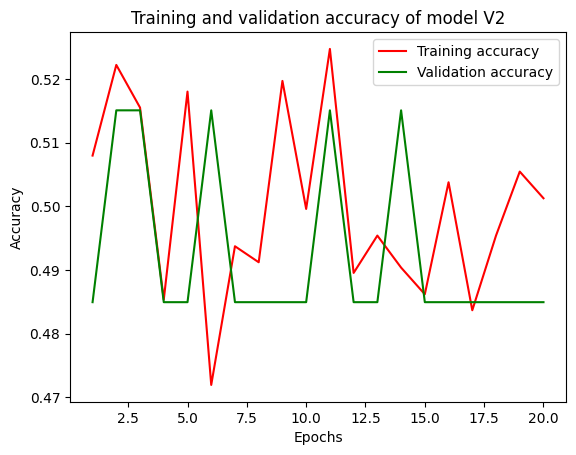

In [52]:
# Extracting accuracy values from the training history
model_2_accuracy = model_v2_history.history['accuracy']
model_2_val_accuracy = model_v2_history.history['val_accuracy']
epochs = range(1, len(model_2_accuracy) + 1)

# Plotting the training and validation accuracy
plt.plot(epochs, model_2_accuracy, c='r', label='Training accuracy')
plt.plot(epochs, model_2_val_accuracy, c='g', label='Validation accuracy')
plt.title('Training and validation accuracy of model V2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # Correctly specifying the location of the legend
plt.show()


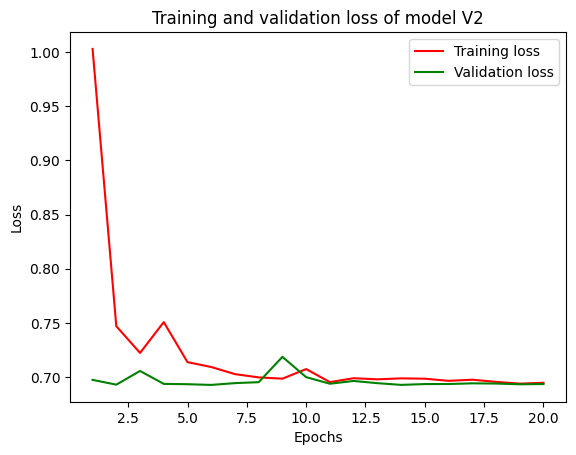

In [53]:

# Extracting loss values from the training history
model_2_loss = model_v2_history.history['loss']
model_2_val_loss = model_v2_history.history['val_loss']
epochs = range(1, len(model_2_loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, model_2_loss, c='r', label='Training loss')
plt.plot(epochs, model_2_val_loss, c='g', label='Validation loss')
plt.title('Training and validation loss of model V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [54]:
model_v2.evaluate(test_sequence_padded,y_test)


10/10 [==============================] - 1s 69ms/step - loss: 0.6935 - accuracy: 0.4849


[0.6935128569602966, 0.48494982719421387]

In [55]:
Y_pred_train=model_v2.predict(train_sequence_padded)
Y_pred_test=model_v2.predict(test_sequence_padded)
print(f"Y_pred_train shape: {Y_pred_train.shape}")
print(f"Y_pred_test shape: {Y_pred_test.shape}")

Y_pred_train=y(Y_pred_train,threshold=0.5)
Y_pred_test=y(Y_pred_test,threshold=0.5)
print(f"accuracy train: {accuracy_score(y_train,Y_pred_train)}")
print(f"accuracy test: {accuracy_score(y_test,Y_pred_test)}")

10/10 [==============================] - 1s 78ms/step
Y_pred_train shape: (1195, 1)
Y_pred_test shape: (299, 1)
accuracy train: 0.503765690376569
accuracy test: 0.48494983277591974


Spam detection  Model version 3 with LSTM but bidirectional :

In [56]:
class SpamDetectionModel_V3(Model):
    def __init__(self, vocab_size, embedding_dim, max_len, dropout_rate=0.2, **kwargs):
        super(SpamDetectionModel_V3, self).__init__(**kwargs)
        self.embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)
        self.bilstm1 = Bidirectional(LSTM(128, return_sequences=True))
        self.dropout1 = Dropout(rate=dropout_rate)
        self.bilstm2 = Bidirectional(LSTM(128, return_sequences=False))
        self.dropout2 = Dropout(rate=dropout_rate)
        self.dense = Dense(1)
        self.activation=Activation('sigmoid')

    def call(self, inputs):
        embeddings = self.embedding(inputs)
        x = self.bilstm1(embeddings)
        x = self.dropout1(x)
        x = self.bilstm2(x)
        x = self.dropout2(x)
        x = self.dense(x)
        output=self.activation(x)
        return output

In [57]:
model_v3=SpamDetectionModel_V3(vocab_size=vocab_size,embedding_dim=embedding_dim,max_len=max_len,dropout_rate=0.2)
input=Input(shape=(max_len,))
output=model_v3(input)
model_v3.summary()

Model: "spam_detection_model_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  8000      
                                                                 
 bidirectional (Bidirection  multiple                  148480    
 al)                                                             
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 bidirectional_1 (Bidirecti  multiple                  394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple      

In [58]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Factor by which the learning rate will be reduced
    patience=3,          # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-5,         # Lower bound on the learning rate
    verbose=1            # Verbosity mode. 1: update messages, 0: silent
)


early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement before stopping the training
    restore_best_weights=True,  # Whether to restore model weights from the epoch with the best value of the monitored metric
    verbose=1            # Verbosity mode. 1: update messages, 0: silent
)

In [59]:
model_v3.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=Adam(learning_rate=1e-3),metrics=['accuracy'])

In [60]:
model_v3_history=model_v3.fit(train_sequence_padded,y_train,epochs=50,validation_data=(test_sequence_padded,y_test),callbacks=[reduce_lr,early_stopping])


Epoch 1/50
38/38 [==============================] - 34s 639ms/step - loss: 0.5205 - accuracy: 0.7448 - val_loss: 0.2825 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - 23s 598ms/step - loss: 0.1997 - accuracy: 0.9314 - val_loss: 0.1881 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 23s 604ms/step - loss: 0.1280 - accuracy: 0.9607 - val_loss: 0.1740 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - 21s 546ms/step - loss: 0.0956 - accuracy: 0.9715 - val_loss: 0.1382 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - 24s 627ms/step - loss: 0.0866 - accuracy: 0.9699 - val_loss: 0.1369 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 6/50
38/38 [==============================] - 24s 640ms/step - loss: 0.0593 - accuracy: 0.9808 - val_loss: 0.1524 - val_accuracy: 0.9599 - lr: 0.0010
Epoch 7/50
38/38 [==============================] - 23s 595ms/st

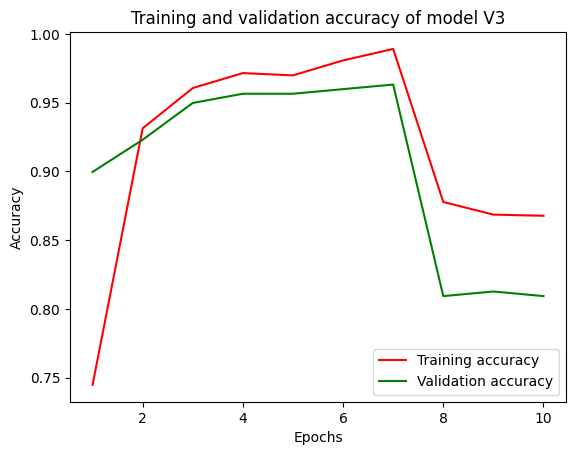

In [61]:
# Extracting accuracy values from the training history
model_3_accuracy = model_v3_history.history['accuracy']
model_3_val_accuracy = model_v3_history.history['val_accuracy']
epochs = range(1, len(model_3_accuracy) + 1)

# Plotting the training and validation accuracy
plt.plot(epochs, model_3_accuracy, c='r', label='Training accuracy')
plt.plot(epochs, model_3_val_accuracy, c='g', label='Validation accuracy')
plt.title('Training and validation accuracy of model V3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # Correctly specifying the location of the legend
plt.show()


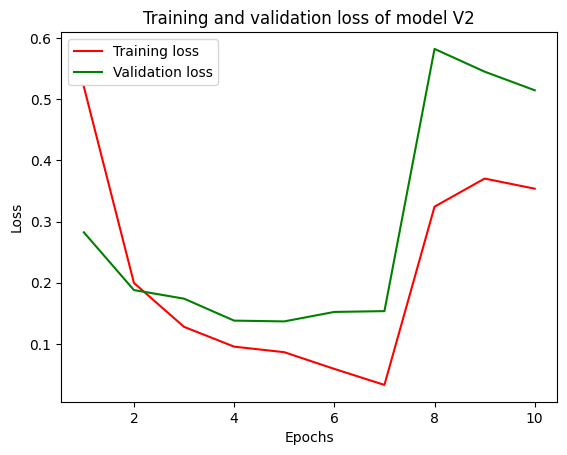

In [62]:
# Extracting loss values from the training history
model_3_loss = model_v3_history.history['loss']
model_3_val_loss = model_v3_history.history['val_loss']
epochs = range(1, len(model_3_loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, model_3_loss, c='r', label='Training loss')
plt.plot(epochs, model_3_val_loss, c='g', label='Validation loss')
plt.title('Training and validation loss of model V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [63]:
model_v3.evaluate(test_sequence_padded,y_test)

10/10 [==============================] - 1s 146ms/step - loss: 0.1369 - accuracy: 0.9565


[0.1368820071220398, 0.95652174949646]

In [64]:
Y_pred_train_v3=model_v3.predict(train_sequence_padded)
Y_pred_test_v3=model_v3.predict(test_sequence_padded)
print(f"Y_pred_train shape: {Y_pred_train_v3.shape}")
print(f"Y_pred_test shape: {Y_pred_test_v3.shape}")

Y_pred_train_v3=y(Y_pred_train_v3,threshold=0.5)
Y_pred_test_v3=y(Y_pred_test_v3,threshold=0.5)
print(f"accuracy train: {accuracy_score(y_train,Y_pred_train_v3)}")
print(f"accuracy test: {accuracy_score(y_test,Y_pred_test_v3)}")

10/10 [==============================] - 1s 133ms/step
Y_pred_train shape: (1195, 1)
Y_pred_test shape: (299, 1)
accuracy train: 0.9841004184100418
accuracy test: 0.9565217391304348


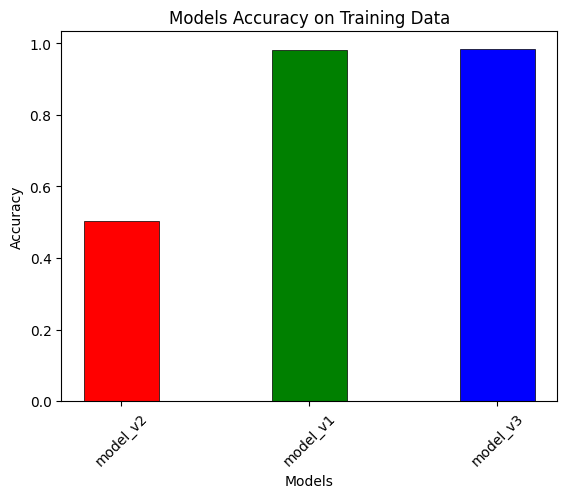

In [70]:

models_accuracy = [
    accuracy_score(y_train, Y_pred_train),    # Accuracy of model 1
    accuracy_score(y_train, y_pred_train),    # Accuracy of model 2
    accuracy_score(y_train, Y_pred_train_v3)  # Accuracy of model 3
]

# Plotting the accuracies
p = np.arange(len(models_accuracy))
plt.bar(p, models_accuracy, color=['r', 'g', 'b'], width=0.4, edgecolor='black', linewidth=0.5)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Models Accuracy on Training Data')
plt.xticks(p, ['model_v2', 'model_v1', 'model_v3'],rotation=45)

plt.show()


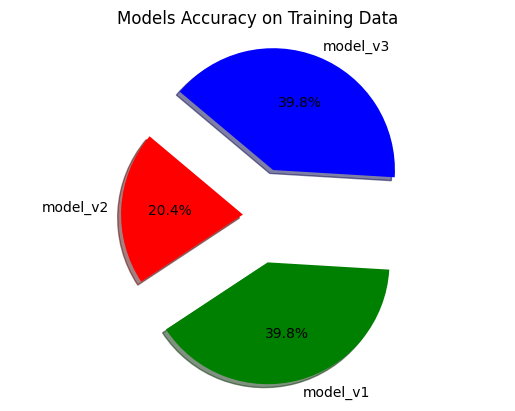

In [74]:
models_accuracy = [
    accuracy_score(y_train, Y_pred_train),    # Accuracy of model 1
    accuracy_score(y_train, y_pred_train),    # Accuracy of model 2
    accuracy_score(y_train, Y_pred_train_v3)  # Accuracy of model 3
]

# Labels for the pie chart
labels = ['model_v2', 'model_v1', 'model_v3']
ex=[0.1,0.4,0.4]
# Plotting the accuracies as a pie chart
plt.pie(models_accuracy, labels=labels, autopct='%1.1f%%', colors=['r', 'g', 'b'], startangle=140,shadow=True,explode=ex)
plt.title('Models Accuracy on Training Data')
plt.axis('equal')
plt.show()

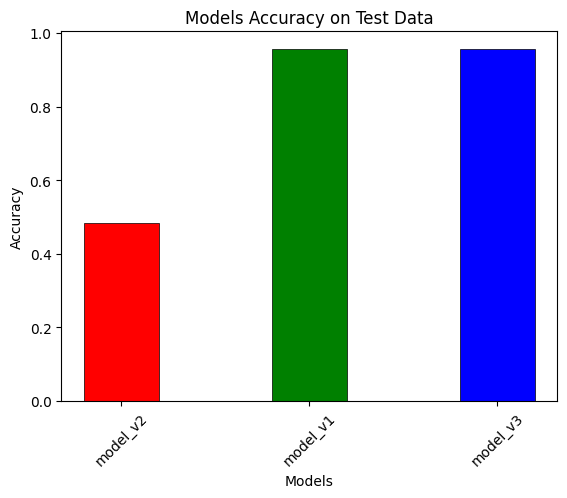

In [75]:

models_accuracy = [
    accuracy_score(y_test, Y_pred_test),    # Accuracy of model 1
    accuracy_score(y_test, y_pred_test),    # Accuracy of model 2
    accuracy_score(y_test, Y_pred_test_v3)  # Accuracy of model 3
]

# Plotting the accuracies
p = np.arange(len(models_accuracy))
plt.bar(p, models_accuracy, color=['r', 'g', 'b'], width=0.4, edgecolor='black', linewidth=0.5)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Models Accuracy on Test Data')
plt.xticks(p, ['model_v2', 'model_v1', 'model_v3'],rotation=45)

plt.show()


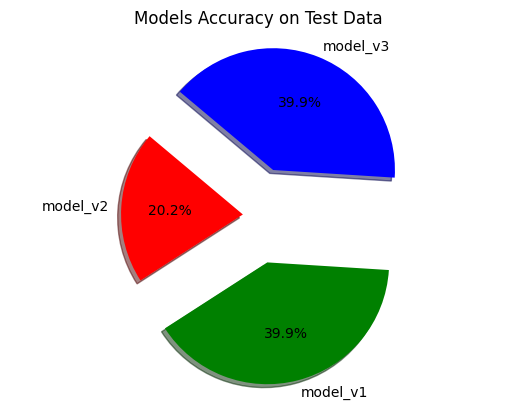

In [76]:

models_accuracy = [
    accuracy_score(y_test, Y_pred_test),    # Accuracy of model 1
    accuracy_score(y_test, y_pred_test),    # Accuracy of model 2
    accuracy_score(y_test, Y_pred_test_v3)  # Accuracy of model 3
]
# Labels for the pie chart
labels = ['model_v2', 'model_v1', 'model_v3']
ex=[0.1,0.4,0.4]
# Plotting the accuracies as a pie chart
plt.pie(models_accuracy, labels=labels, autopct='%1.1f%%', colors=['r', 'g', 'b'], startangle=140,shadow=True,explode=ex)
plt.title('Models Accuracy on Test Data')
plt.axis('equal')
plt.show()